In [1]:
import torch
import clip
import os
import sys
import torch
import time
import shutil
from torchvision.transforms import ToPILImage

base_directory = "../"
sys.path.insert(0, base_directory)

output_directory = "./output/noise-tests/sd2-notebook/clip_image_encoder/"

try: 
    shutil.rmtree(output_directory)
except Exception as e:
    print(e, "\n", "Creating the path...")
    os.makedirs(output_directory, exist_ok=True)
else:
    os.makedirs(output_directory, exist_ok=True)


from stable_diffusion2.stable_diffusion import StableDiffusion
from labml.monit import section
# from stable_diffusion2.utils.utils import SectionManager as section
from stable_diffusion2.utils.model import *
from stable_diffusion2.utils.utils import *
from stable_diffusion2.model.clip.clip_embedder import CLIPTextEmbedder

from pathlib import Path
from os.path import join

In [2]:
device = check_device(None)
sd = StableDiffusion(device=device)
get_memory_status()

INFO: `device` is None. Falling back to current device.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 11086 MiB
Used: 1201 MiB


In [3]:
# let's start embedding a prompt and saving it

sd.quick_initialize().load_clip_embedder().load_submodels()
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 10124 MiB
Used: 2163 MiB


In [4]:
# get the text embeddings
uncond, cond = sd.get_text_conditioning(uncond_scale = 7.5, prompts = ["A computer virus dancing tango."], batch_size = 1)
get_memory_status()

Total: 12287 MiB
Free: 9620 MiB
Used: 2667 MiB


In [5]:
# check their shape
uncond.shape, cond.shape

(torch.Size([1, 77, 768]), torch.Size([1, 77, 768]))

In [6]:
# save them to disk
torch.save(uncond, join(output_directory, "uncond.pt"))
torch.save(uncond, join(output_directory, "cond.pt"))

In [7]:
# load the unet, needed for the sampling
sd.model.load_unet()
get_memory_status()

Total: 12287 MiB
Free: 6308 MiB
Used: 5979 MiB


In [8]:
# load the decoder, needed for getting the sampled image back from the latent space
sd.model.load_autoencoder().load_decoder()
get_memory_status()

Autoencoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\autoencoder.ckpt
Decoder loaded from: c:\Users\igor-\.cloned\kcg-ml-sd1p4\input\model\autoencoder\decoder.ckpt
Total: 12287 MiB
Free: 6120 MiB
Used: 6167 MiB


In [9]:
images = sd.generate_images_from_embeddings(null_prompt = uncond, embedded_prompt=cond, batch_size = 4)
get_memory_status()

cond shape:  torch.Size([4, 77, 768])
uncond shape:  torch.Size([1, 77, 768])


HTML(value='<pre  style="overflow-x: scroll;">Sample...</pre>')

Total: 12287 MiB
Free: 0 MiB
Used: 12287 MiB


In [10]:
images.shape

torch.Size([4, 3, 512, 512])

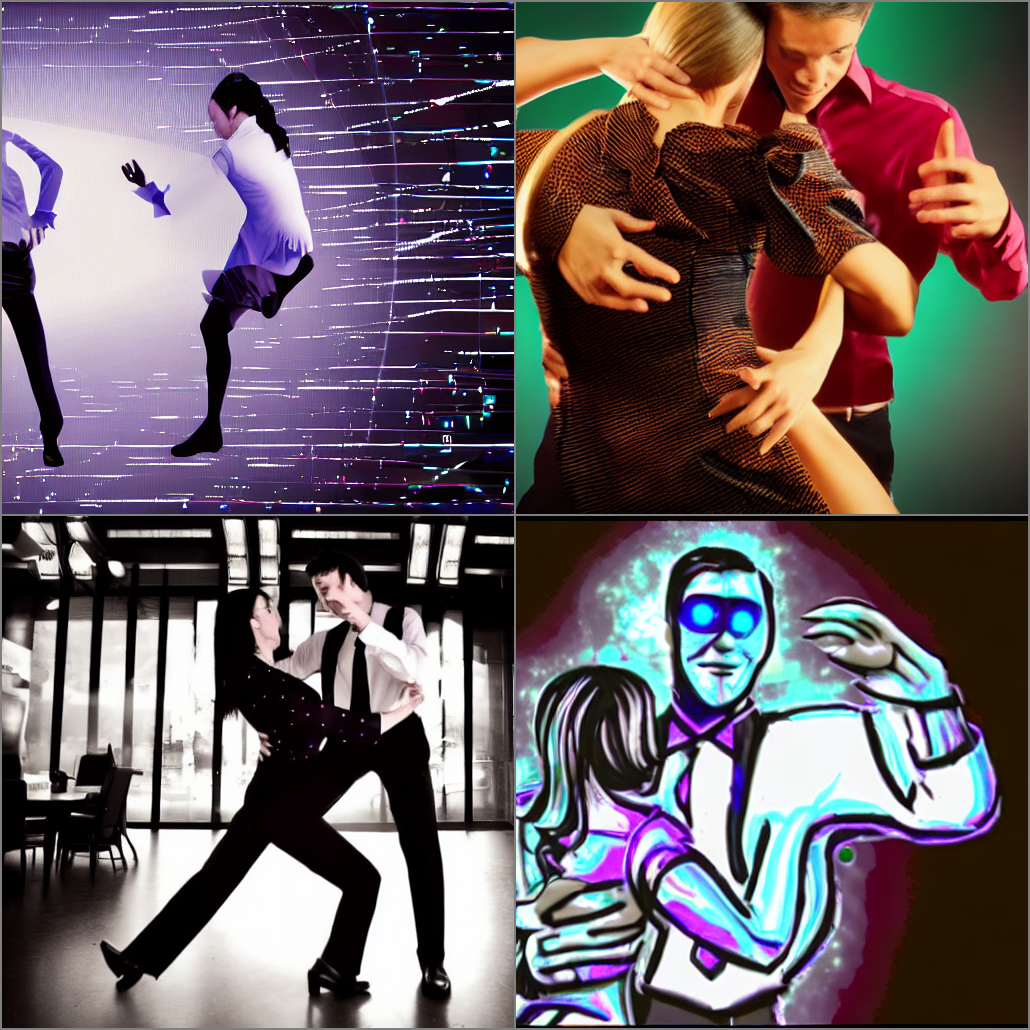

In [14]:
grid = torchvision.utils.make_grid(images, nrow=2, normalize=False, range=(-1, 1))
to_pil(grid)